# Credit Card Fraud Detection Project, Pt. 2: The Purpose of Scaling and Balancing

# Introduction

## Recap
In Part 1 (https://colab.research.google.com/drive/1aEs3QTsD_Gdt8cjPyn0QXqHV4ZPNtVvb#scrollTo=ERlk1ma_XXcG&uniqifier=1), we preprocessed the data, transformed and standardized the transaction amount feature, determined the performance metrics, and tested a few algorithms.

## Upcoming Steps
Previously, I only standardized the amount feature because the other features were all PCA engineered with reasonably close distributions. We will standardize these PCA features using Standard Scaler (as we did on the Amount feature, should work given the distributions for these features being close enough to bell-shaped), and compare model performance using the same algorithms selected in Part 1.

We will move forward with the data being standardized or kept the same (depending on which data led to better performance). Using this data, we will then try oversampling the minority class using SMOTE, as well as undersampling by removing observations from the majority class. We will use the same selected algorithms.

# Initial Steps

In [ ]:
# Link to Kaggle
!mkdir ~/.kaggle
!cp "/content/drive/MyDrive/Portfolio projects/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Define the base file location for pathlib files
base_path = '/content/drive/MyDrive/Portfolio projects/Credit Card Fraud Detection/joblib files/'

In [ ]:
# Import statements
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_recall_curve, auc, precision_score, recall_score, accuracy_score, fbeta_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib
import time
from pathlib import Path
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

pd.set_option('display.max_columns', None)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# Import train and test data from Part 1
X_train = joblib.load(base_path + 'X_train.joblib')
y_train = joblib.load(base_path + 'y_train.joblib')
X_test = joblib.load(base_path + 'X_test.joblib')
y_test = joblib.load(base_path + 'y_test.joblib')

In [ ]:
# Create/retrieve model scores and PR-Curves for part 2

if Path(base_path + 'model_scores_pt2_scaled.joblib').is_file():
  model_scores_pt2_scaled = joblib.load(base_path + 'model_scores_pt2_scaled.joblib')
else:
  model_scores_pt2_scaled = {}

if Path(base_path + 'model_pr_curves_pt2_scaled.joblib').is_file():
  model_pr_curves_pt2_scaled = joblib.load(base_path + 'model_pr_curves_pt2_scaled.joblib')
else:
  model_pr_curves_pt2_scaled = {}

In [ ]:
# Retrieve model scores and PR-Curves for part 1
model_scores_pt1 = joblib.load(base_path + 'model_scores_pt1.joblib')
model_pr_curves_pt1 = joblib.load(base_path + 'model_pr_curves_pt1.joblib')

In [ ]:
# Functions created in Part 1
# Slightly modified to handle future models

################################################################################

# AUC-PR
def auc_pr_score(y_true, y_pred_proba):
  precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
  return auc(recall, precision)

################################################################################

def plot_pr_curves(model_pr_curves):
  # Set up the plot
  plt.figure(figsize=(8, 6))

  # Plot PR curves for each model stored in model_pr_curves_pt1
  for model_name, metrics in model_pr_curves.items():
      precision = metrics['precision']
      recall = metrics['recall']

      plt.plot(recall, precision, label=f'{model_name}')

  # Customize the plot
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve for Different Models')
  plt.legend(loc='best')
  plt.grid(True)

  # Show the plot
  plt.show()

################################################################################

# Helper function to evaluate model after fitting
def evaluate(name, y_test, y_pred, y_pred_proba, y_train, time_elapsed, scores, scores_name):
  minutes, seconds = divmod(time_elapsed, 60)
  scores[name] = {
    "Accuracy Score": f"{accuracy_score(y_test, y_pred):.3f}",
    "Precision Score": f"{precision_score(y_test, y_pred):.3f}",
    "Recall Score": f"{recall_score(y_test, y_pred):.3f}",
    "F1 Score": f"{f1_score(y_test, y_pred):.3f}",
    "F0.5 Score": f"{fbeta_score(y_test, y_pred, beta=0.5):.3f}",
    "F2 Score": f"{fbeta_score(y_test, y_pred, beta=2):.3f}",
    "AUC-PR": f"{auc_pr_score(y_test, y_pred_proba):.3f}",
    "Time Elapsed": f"{minutes:.0f} minutes {round(seconds)} seconds"
  }
  joblib.dump(scores, Path(base_path + scores_name + '.joblib'))

################################################################################

# Main function
def fit_evaluate(name, model, X_train, y_train, scores, scores_name, pr, pr_name):

  # Time the model fitting/prediction
  start_time = time.time()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  y_pred_proba = model.predict_proba(X_test)[:,1]
  precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
  time_elapsed = time.time() - start_time

  # Evaluate model performance with helper method
  evaluate(name, y_test, y_pred, y_pred_proba, y_train, time_elapsed, scores, scores_name)

  # Store PR curve coordinates
  pr[name] = {
        "precision": precision,
        "recall": recall,
        "thresholds": thresholds
    }
  joblib.dump(pr, Path(base_path + pr_name + '.joblib'))

################################################################################

# Print metrics
def print_metrics(name, scores):
  print(name)
  for key, value in scores[name].items():
    print(f"{key}: {value}")

################################################################################

# Scaling

In [ ]:
# Create copies of the train and test data to be standardized
# NOTE: Will create copies to be balanced, but first need to determine standardization
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

In [ ]:
# Scale all of the data and keep them as dataframes
# NOTE: Scaling Amount again will not change the initial results because of the std. dev. remaining 1, mean remaining 0
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [ ]:
# See the first few rows of the standardized data
X_train_scaled.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount_log_scaled
226238,1.147198,-1.042032,-1.428821,-1.817824,0.727198,2.695677,-1.489310,0.735746,-1.152704,1.462945,-0.231446,-0.711064,0.366408,-0.326768,0.310782,-0.662651,0.453250,-0.218587,-0.391838,-0.427196,-0.208573,-0.068205,0.445379,1.130202,-0.420363,-0.331281,0.092782,-0.156193,0.205510
134253,-0.677911,0.991948,0.394668,-0.025642,-0.301198,-0.728240,0.175615,0.629070,-1.156290,-0.447680,1.410721,1.775904,1.262547,0.905688,-0.292136,0.449243,-0.313979,-0.413008,0.481434,-0.089833,-0.332248,-1.307141,0.518036,0.851069,-1.367338,-0.554255,-0.049864,0.153831,-0.650843
186465,0.977654,0.016205,-1.386701,0.092688,0.850613,0.458823,-0.019872,0.154370,0.262056,-0.461780,1.504818,1.047111,0.479232,-0.720785,1.053518,-0.319177,0.941691,-0.189831,-1.223343,-0.277973,0.405040,1.512732,-0.071350,-2.788905,0.202924,0.015479,0.111329,-0.165820,-0.233468
149493,0.927561,0.195261,0.208736,2.739855,0.032003,0.772348,-0.613532,0.199999,0.625478,1.070513,1.312744,-1.788757,2.192638,1.300716,-2.229054,1.536999,-0.562862,0.982345,-2.082239,-0.301091,0.190793,0.966846,0.278559,1.160348,-0.407893,-0.021447,-0.049724,-0.119582,-0.150483
18461,0.695218,-0.676118,0.363661,-1.090812,-0.882507,0.209618,-1.002620,0.182243,-1.911610,1.393019,1.705896,0.014460,0.332457,-0.045069,0.516509,-0.756636,0.934808,-0.768730,-0.728156,-0.477066,-0.473576,-0.878722,0.404329,-0.568164,-0.123705,-0.913882,0.155776,0.037290,0.037881


In [ ]:
# As we can see below, the mean for each feature is around 0, std. dev. around 1
X_train_scaled.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount_log_scaled
count,2.269800e+05,2.269800e+05,2.269800e+05,2.269800e+05,2.269800e+05,2.269800e+05,2.269800e+05,2.269800e+05,2.269800e+05,2.269800e+05,2.269800e+05,2.269800e+05,2.269800e+05,2.269800e+05,2.269800e+05,2.269800e+05,2.269800e+05,2.269800e+05,2.269800e+05,2.269800e+05,2.269800e+05,2.269800e+05,2.269800e+05,2.269800e+05,2.269800e+05,2.269800e+05,2.269800e+05,2.269800e+05,2.269800e+05
mean,1.627818e-18,-1.220864e-17,8.170396e-18,-2.657727e-17,1.029908e-17,-1.139473e-17,-8.827784e-18,-1.095647e-19,7.763442e-18,7.810398e-18,2.067642e-17,3.756504e-19,4.726934e-18,-1.989382e-17,2.879986e-18,-2.003469e-17,6.417361e-19,3.396506e-18,1.922078e-17,-7.137358e-18,2.504336e-18,-4.507805e-18,3.599983e-18,-6.933880e-18,3.944329e-18,-1.790600e-17,2.754770e-18,2.629553e-18,-1.884513e-17
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-2.896978e+01,-4.407711e+01,-2.234715e+01,-4.009399e+00,-2.360704e+01,-1.976620e+01,-3.629354e+01,-6.261354e+01,-1.227654e+01,-2.290893e+01,-4.709672e+00,-1.869652e+01,-5.826074e+00,-2.013304e+01,-4.921689e+00,-1.617467e+01,-2.984434e+01,-1.134666e+01,-8.866641e+00,-3.113533e+01,-4.822625e+01,-1.509353e+01,-7.161198e+01,-4.682405e+00,-1.973739e+01,-5.411177e+00,-5.777945e+01,-3.595366e+01,-1.905614e+00
25%,-4.729207e-01,-3.610299e-01,-5.900694e-01,-5.979342e-01,-5.104934e-01,-5.794173e-01,-4.615785e-01,-1.782359e-01,-5.862840e-01,-4.973148e-01,-7.476340e-01,-4.081399e-01,-6.518439e-01,-4.460155e-01,-6.365689e-01,-5.357462e-01,-5.734887e-01,-5.971811e-01,-5.604700e-01,-2.793888e-01,-3.173299e-01,-7.478445e-01,-2.592278e-01,-5.857339e-01,-6.094946e-01,-6.790466e-01,-1.848734e-01,-1.644630e-01,-7.580600e-01
50%,6.845720e-03,4.205161e-02,1.168841e-01,-1.409621e-02,-4.223030e-02,-2.070140e-01,3.278904e-02,1.919649e-02,-4.563565e-02,-8.524960e-02,-3.084881e-02,1.390690e-01,-1.247497e-02,5.290931e-02,5.280008e-02,7.676004e-02,-7.709835e-02,-4.077572e-03,5.124574e-03,-8.268005e-02,-4.125291e-02,1.014864e-02,-1.784637e-02,6.780436e-02,3.051999e-02,-1.080423e-01,-4.664138e-04,3.226416e-02,-1.036679e-02
75%,6.729237e-01,4.891300e-01,6.802567e-01,5.246624e-01,4.489577e-01,3.017549e-01,4.752835e-01,2.785179e-01,5.457581e-01,4.252043e-01,7.265811e-01,6.212007e-01,6.661463e-01,5.167635e-01,7.089362e-01,5.978267e-01,4.713522e-01,5.973403e-01,5.641967e-01,1.750155e-01,2.573169e-01,7.300746e-01,2.370799e-01,7.264178e-01,6.728106e-01,4.980486e-01,2.297090e-01,2.388624e-01,7.314265e-01
max,1.258110e+00,1.337482e+01,6.223468e+00,1.191100e+01,2.559261e+01,1.616674e+01,2.858050e+01,1.711002e+01,1.425697e+01,2.212738e+01,1.179867e+01,7.908741e+00,4.597194e+00,1.103274e+01,6.370821e+00,8.078423e+00,1.097616e+01,6.017618e+00,6.847533e+00,5.190234e+01,3.766250e+01,1.449963e+01,3.600559e+01,6.629588e+00,1.441505e+01,7.306091e+00,3.110961e+01,1.039050e+02,4.063491e+00


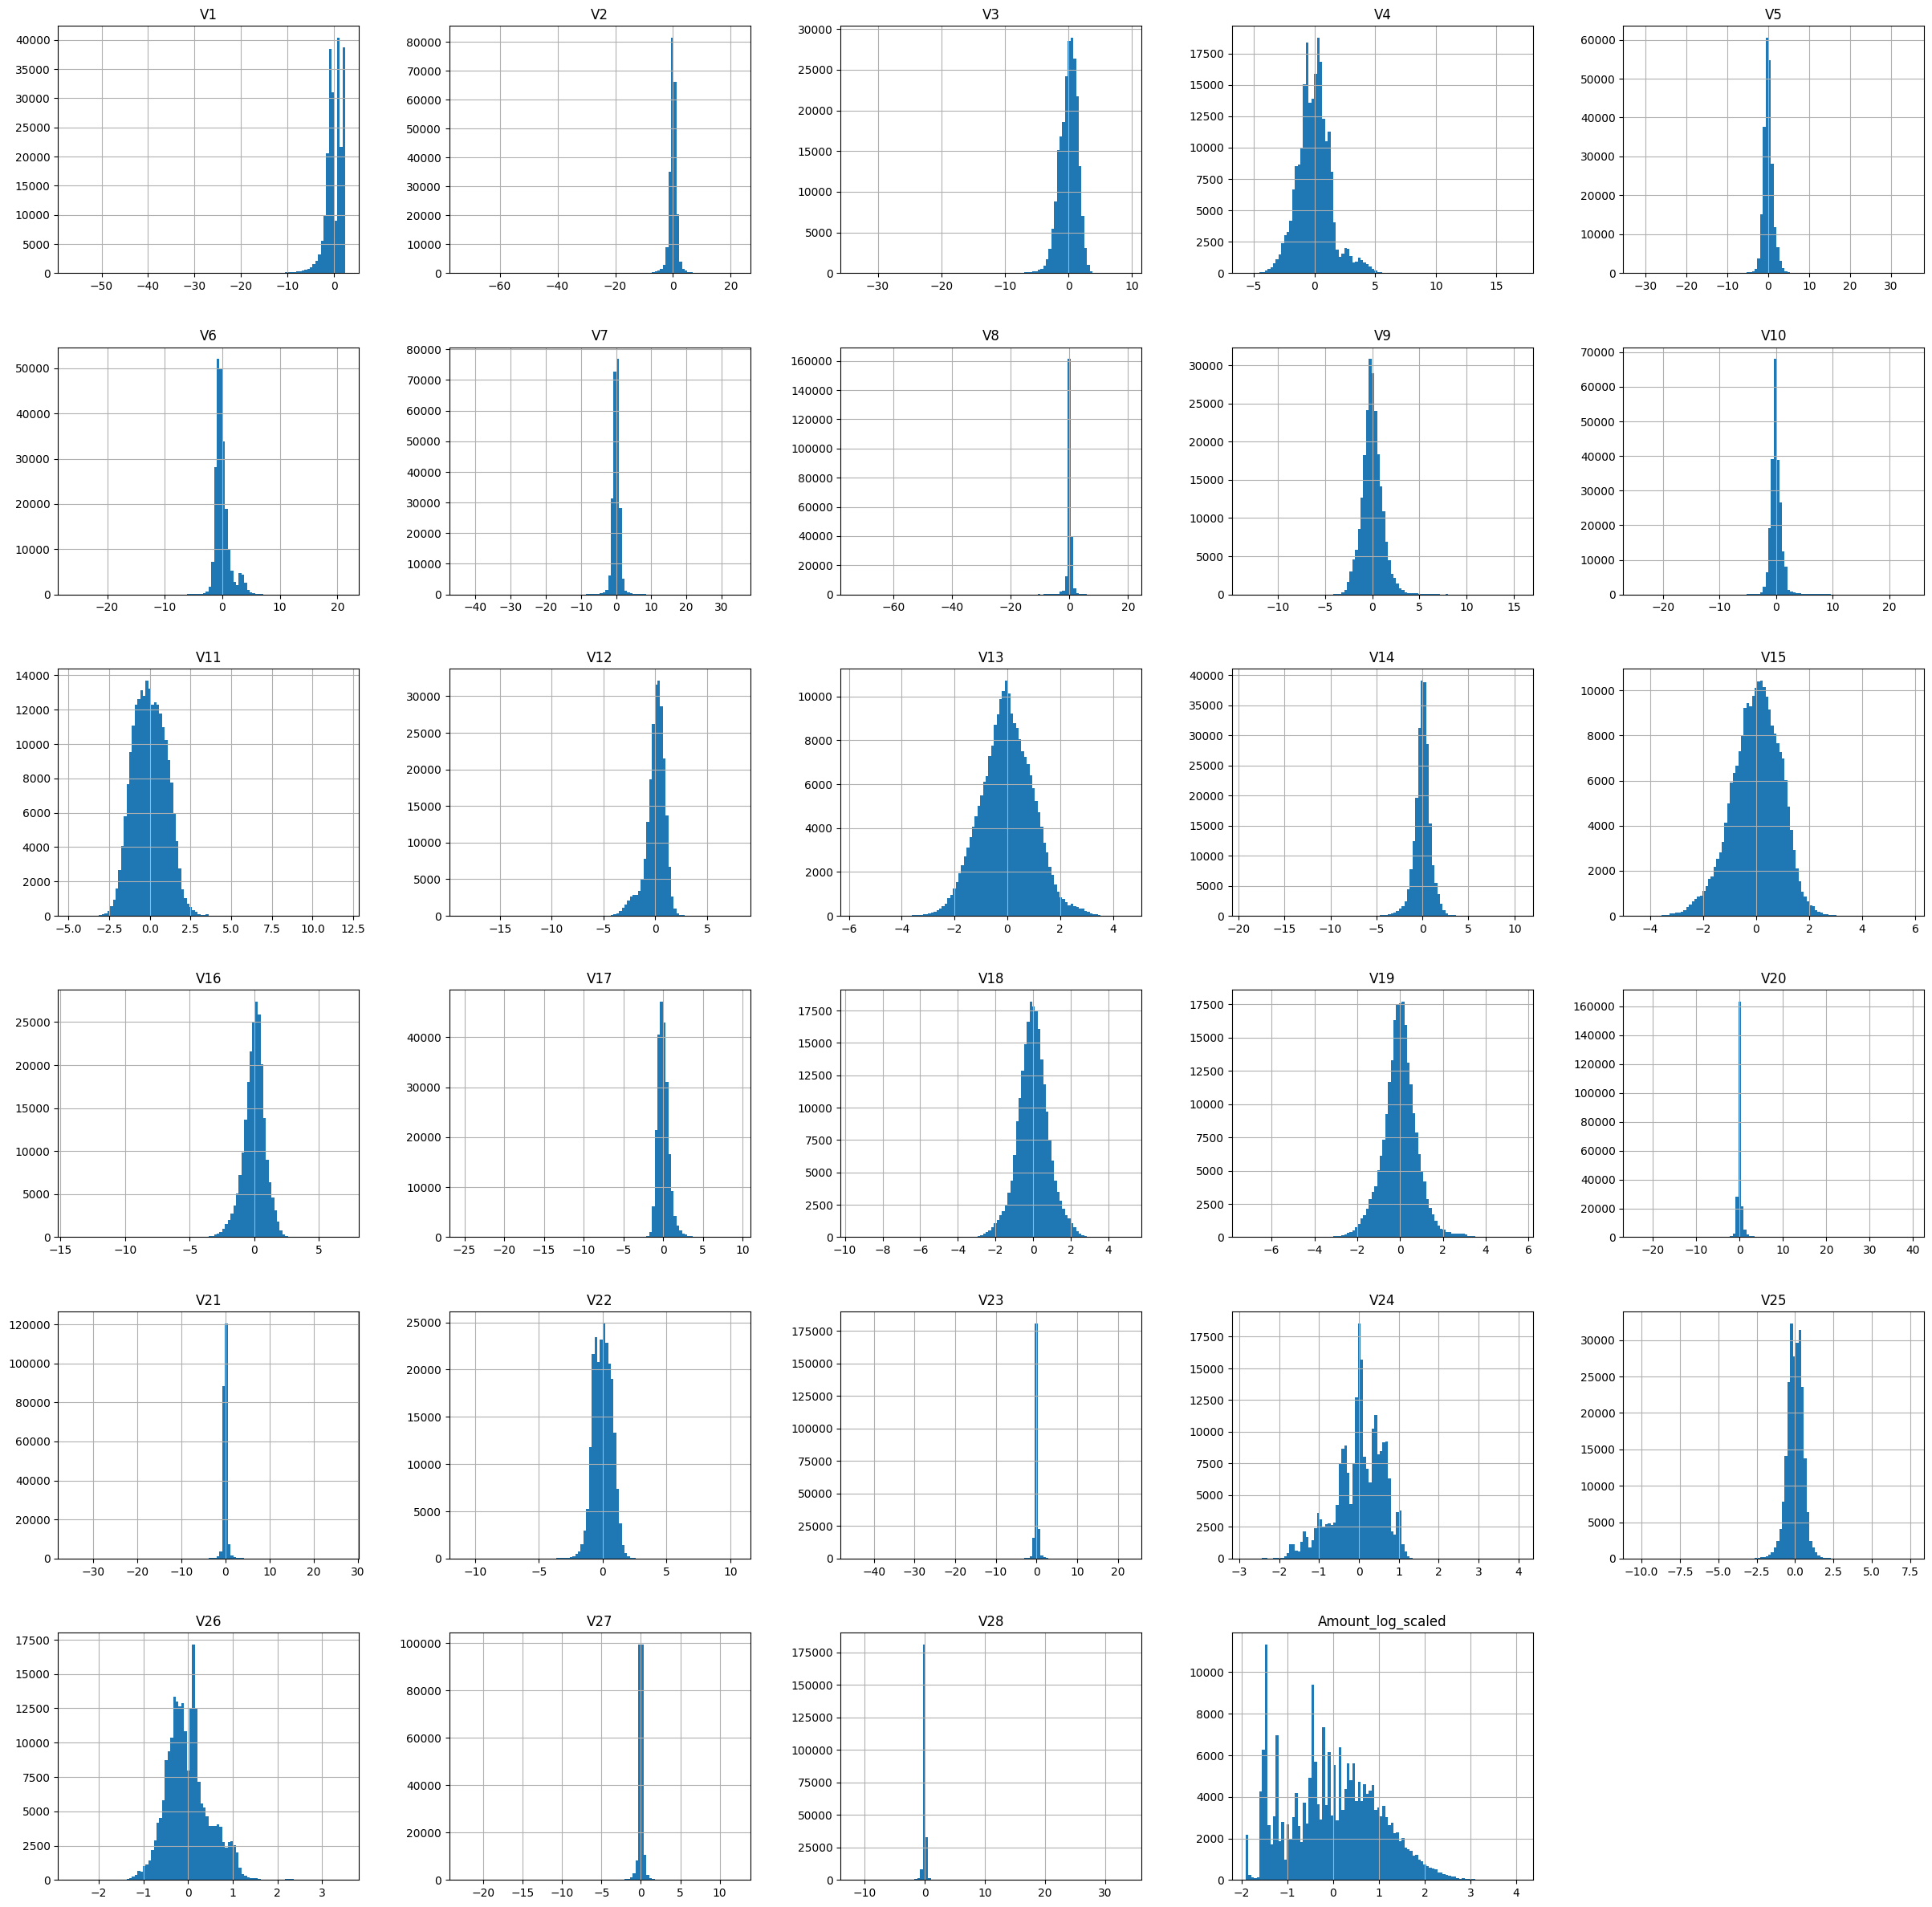

In [ ]:
# Visualize distribution of all features in the training dataset after scaling
X_train.hist(bins=100, figsize=(30,30))
plt.show()

# Modeling with Scaled Data

In [ ]:
if 'Logistic Regression' not in model_scores_pt2_scaled:
    log_reg = LogisticRegression(random_state=42)
    fit_evaluate('Logistic Regression', log_reg, X_train_scaled, y_train, model_scores_pt2_scaled, 'model_scores_pt2_scaled', model_pr_curves_pt2_scaled, 'model_pr_curves_pt2_scaled')

print('With Scaling:')
print_metrics('Logistic Regression', model_scores_pt2_scaled)
print()
print('Without Scaling:')
print_metrics('Logistic Regression', model_scores_pt1)

With Scaling:
Logistic Regression
Accuracy Score: 0.999
Precision Score: 0.784
Recall Score: 0.611
F1 Score: 0.686
F0.5 Score: 0.742
F2 Score: 0.639
AUC-PR: 0.679
Time Elapsed: 0 minutes 1 seconds

Without Scaling:
Logistic Regression
Accuracy Score: 0.999
Precision Score: 0.864
Recall Score: 0.600
F1 Score: 0.708
F0.5 Score: 0.794
F2 Score: 0.639
AUC-PR: 0.700
Time Elapsed: 0 minutes 1 seconds


Logistic Regression performed better in most metrics when trained on the data that was not scaled. However, the recall rate was higher on the scaled data, and the F2-Score was the same.

It's hard to say which model performed better given the tradeoffs. The recall performs better, but not by much. The precision takes a hit, but the slight recall boost may make it worthwhile. In this instance, the impact score/scoring function idea mentioned in Part 1 would be of use.

In [ ]:
if 'Decision Tree' not in model_scores_pt2_scaled:
  decision_tree = DecisionTreeClassifier(random_state=42)
  fit_evaluate('Decision Tree', decision_tree, X_train_scaled, y_train, model_scores_pt2_scaled, 'model_scores_pt2_scaled', model_pr_curves_pt2_scaled, 'model_pr_curves_pt2_scaled')

print('With Scaling:')
print_metrics('Decision Tree', model_scores_pt2_scaled)
print()
print('Without Scaling:')
print_metrics('Decision Tree', model_scores_pt1)

With Scaling:
Decision Tree
Accuracy Score: 0.994
Precision Score: 0.158
Recall Score: 0.653
F1 Score: 0.255
F0.5 Score: 0.186
F2 Score: 0.402
AUC-PR: 0.406
Time Elapsed: 0 minutes 34 seconds

Without Scaling:
Decision Tree
Accuracy Score: 0.999
Precision Score: 0.714
Recall Score: 0.684
F1 Score: 0.699
F0.5 Score: 0.708
F2 Score: 0.690
AUC-PR: 0.700
Time Elapsed: 0 minutes 28 seconds


Decision Tree performed better in every metric when trained on the unscaled data

In [ ]:
if 'KNN' not in model_scores_pt2_scaled:
    knn = KNeighborsClassifier(n_neighbors=5)
    fit_evaluate('KNN', knn, X_train_scaled, y_train, model_scores_pt2_scaled, 'model_scores_pt2_scaled', model_pr_curves_pt2_scaled, 'model_pr_curves_pt2_scaled')

print('With Scaling:')
print_metrics('KNN', model_scores_pt2_scaled)
print()
print('Without Scaling:')
print_metrics('KNN', model_scores_pt1)

With Scaling:
KNN
Accuracy Score: 0.999
Precision Score: 0.940
Recall Score: 0.663
F1 Score: 0.778
F0.5 Score: 0.868
F2 Score: 0.705
AUC-PR: 0.820
Time Elapsed: 3 minutes 3 seconds

Without Scaling:
KNN
Accuracy Score: 0.999
Precision Score: 0.957
Recall Score: 0.705
F1 Score: 0.812
F0.5 Score: 0.893
F2 Score: 0.744
AUC-PR: 0.847
Time Elapsed: 3 minutes 31 seconds


KNN performed better in every metric when trained on the unscaled data

In [ ]:
if 'Random Forest' not in model_scores_pt2_scaled:
  rf = RandomForestClassifier(random_state=42)
  fit_evaluate('Random Forest', rf, X_train_scaled, y_train, model_scores_pt2_scaled, 'model_scores_pt2_scaled', model_pr_curves_pt2_scaled, 'model_pr_curves_pt2_scaled')

print('With Scaling:')
print_metrics('Random Forest', model_scores_pt2_scaled)
print()
print('Without Scaling:')
print_metrics('Random Forest', model_scores_pt1)

With Scaling:
Random Forest
Accuracy Score: 0.999
Precision Score: 0.885
Recall Score: 0.726
F1 Score: 0.798
F0.5 Score: 0.848
F2 Score: 0.753
AUC-PR: 0.753
Time Elapsed: 5 minutes 22 seconds

Without Scaling:
Random Forest
Accuracy Score: 1.000
Precision Score: 0.972
Recall Score: 0.737
F1 Score: 0.838
F0.5 Score: 0.914
F2 Score: 0.774
AUC-PR: 0.802
Time Elapsed: 5 minutes 24 seconds


Random Forest performed better in every metric when trained on unscaled data

In [ ]:
if 'XGBoost' not in model_scores_pt2_scaled:
  xgb = XGBClassifier(random_state=42)
  fit_evaluate('XGBoost', xgb, X_train_scaled, y_train, model_scores_pt2_scaled, 'model_scores_pt2_scaled', model_pr_curves_pt2_scaled, 'model_pr_curves_pt2_scaled')

print('With Scaling:')
print_metrics('XGBoost', model_scores_pt2_scaled)
print()
print('Without Scaling:')
print_metrics('XGBoost', model_scores_pt1)

With Scaling:
XGBoost
Accuracy Score: 0.999
Precision Score: 0.877
Recall Score: 0.747
F1 Score: 0.807
F0.5 Score: 0.847
F2 Score: 0.770
AUC-PR: 0.766
Time Elapsed: 0 minutes 6 seconds

Without Scaling:
XGBoost
Accuracy Score: 1.000
Precision Score: 0.973
Recall Score: 0.747
F1 Score: 0.845
F0.5 Score: 0.917
F2 Score: 0.784
AUC-PR: 0.827
Time Elapsed: 0 minutes 8 seconds


XGBoost performed better in every metric when trained on unscaled data

In [ ]:
if 'LightGBM' not in model_scores_pt2_scaled:
  lgbm = LGBMClassifier(random_state=42)
  fit_evaluate('LightGBM', lgbm, X_train_scaled, y_train, model_scores_pt2_scaled, 'model_scores_pt2_scaled', model_pr_curves_pt2_scaled, 'model_pr_curves_pt2_scaled')

print('With Scaling:')
print_metrics('LightGBM', model_scores_pt2_scaled)
print()
print('Without Scaling:')
print_metrics('LightGBM', model_scores_pt1)

With Scaling:
LightGBM
Accuracy Score: 0.996
Precision Score: 0.239
Recall Score: 0.547
F1 Score: 0.332
F0.5 Score: 0.269
F2 Score: 0.435
AUC-PR: 0.353
Time Elapsed: 0 minutes 5 seconds

Without Scaling:
LightGBM
Accuracy Score: 0.997
Precision Score: 0.221
Recall Score: 0.358
F1 Score: 0.273
F0.5 Score: 0.239
F2 Score: 0.318
AUC-PR: 0.231
Time Elapsed: 0 minutes 5 seconds


LightGBM performs better when trained on the scaled data, but the performance is still poor

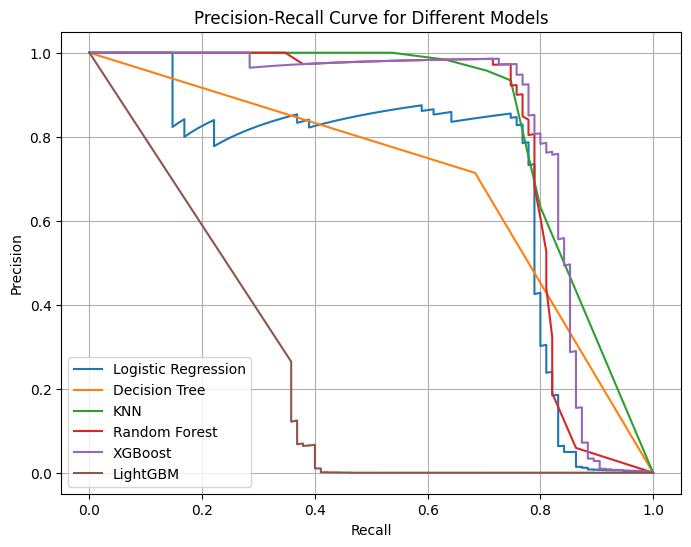

In [ ]:
# Plot the PR-Curves
plot_pr_curves(model_pr_curves_pt1)

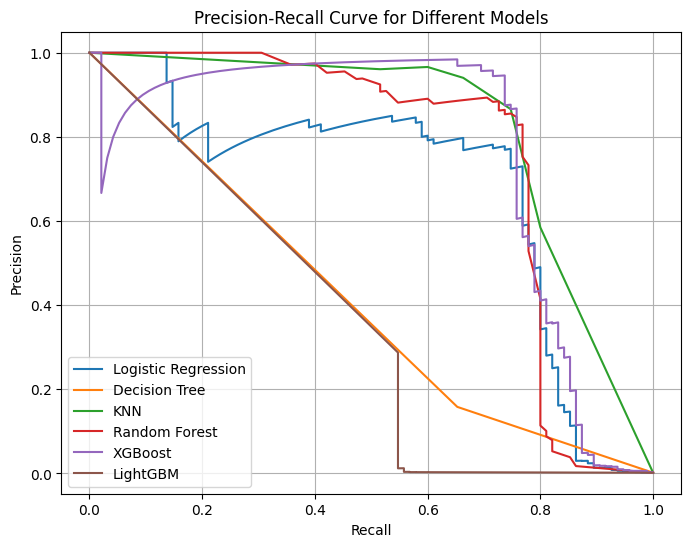

In [ ]:
# Plot the PR-Curves
plot_pr_curves(model_pr_curves_pt2_scaled)

Results: The unscaled data worked better in 5/6 instances. LightGBM was the one algorithm which improved performance when trained on scaled data, but it didn't perform well in either instance.

While standardization/normalization can be important, there are instances where they can be detrimental to the model.

**We will stick with the unscaled data used in Part 1**

# Balancing: SMOTE and Random Undersampling

In [ ]:
# Use SMOTE to add synthetic data to balance the classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
# Class count after SMOTE
y_train_smote.value_counts()

,count
Class,
0,226602
1,226602


In [ ]:
# Use Random Undersampling to remove instances of the majority class and balance both classes
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [ ]:
# Class Count after Random Undersampling
y_train_rus.value_counts()

,count
Class,
0,378
1,378


# Modeling with Balanced Data

In [ ]:
# Create/load scores and curve dictionaries

if Path(base_path + 'model_scores_pt2_smote.joblib').is_file():
  model_scores_pt2_smote = joblib.load(base_path + 'model_scores_pt2_smote.joblib')
else:
  model_scores_pt2_smote = {}

if Path(base_path + 'model_scores_pt2_rus.joblib').is_file():
  model_scores_pt2_rus = joblib.load(base_path + 'model_scores_pt2_rus.joblib')
else:
  model_scores_pt2_rus = {}



if Path(base_path + 'model_pr_curves_pt2_smote.joblib').is_file():
  model_pr_curves_pt2_smote = joblib.load(base_path + 'model_pr_curves_pt2_smote.joblib')
else:
  model_pr_curves_pt2_smote = {}

if Path(base_path + 'model_pr_curves_pt2_rus.joblib').is_file():
  model_pr_curves_pt2_rus = joblib.load(base_path + 'model_pr_curves_pt2_rus.joblib')
else:
  model_pr_curves_pt2_rus = {}

In [ ]:
if 'Logistic Regression' not in model_scores_pt2_smote:
    log_reg = LogisticRegression(random_state=42)
    fit_evaluate('Logistic Regression', log_reg, X_train_smote, y_train_smote, model_scores_pt2_smote, 'model_scores_pt2_smote', model_pr_curves_pt2_smote, 'model_pr_curves_pt2_smote')

if 'Logistic Regression' not in model_scores_pt2_rus:
    log_reg = LogisticRegression(random_state=42)
    fit_evaluate('Logistic Regression', log_reg, X_train_rus, y_train_rus, model_scores_pt2_rus, 'model_scores_pt2_rus', model_pr_curves_pt2_rus, 'model_pr_curves_pt2_rus')

print('SMOTE:')
print_metrics('Logistic Regression', model_scores_pt2_smote)
print()
print('Random Undersampling:')
print_metrics('Logistic Regression', model_scores_pt2_rus)
print()
print('Imbalanced:')
print_metrics('Logistic Regression', model_scores_pt1)


SMOTE:
Logistic Regression
Accuracy Score: 0.973
Precision Score: 0.052
Recall Score: 0.874
F1 Score: 0.099
F0.5 Score: 0.064
F2 Score: 0.211
AUC-PR: 0.712
Time Elapsed: 0 minutes 5 seconds

Random Undersampling:
Logistic Regression
Accuracy Score: 0.973
Precision Score: 0.051
Recall Score: 0.874
F1 Score: 0.096
F0.5 Score: 0.063
F2 Score: 0.207
AUC-PR: 0.642
Time Elapsed: 0 minutes 0 seconds

Imbalanced:
Logistic Regression
Accuracy Score: 0.999
Precision Score: 0.864
Recall Score: 0.600
F1 Score: 0.708
F0.5 Score: 0.794
F2 Score: 0.639
AUC-PR: 0.700
Time Elapsed: 0 minutes 1 seconds


NOTE: These evaluations are based on the default threshold. We will examine model performance at different thresholds using PR-Curve at the end
- Random Undersampling sees an 80% drop in precision and is at only 5%, but also sees recall rise almost 30% to 87.4%
- SMOTE's performance is roughly identical to Random Undersampling in this case, but has a higher AUC-PR than both because of its more consistent performance at different thresholds


In [ ]:
if 'Decision Tree' not in model_scores_pt2_smote:
  decision_tree = DecisionTreeClassifier(random_state=42)
  fit_evaluate('Decision Tree', decision_tree, X_train_smote, y_train_smote, model_scores_pt2_smote, 'model_scores_pt2_smote', model_pr_curves_pt2_smote, 'model_pr_curves_pt2_smote')

if 'Decision Tree' not in model_scores_pt2_rus:
  decision_tree = DecisionTreeClassifier(random_state=42)
  fit_evaluate('Decision Tree', decision_tree, X_train_rus, y_train_rus, model_scores_pt2_rus, 'model_scores_pt2_rus', model_pr_curves_pt2_rus, 'model_pr_curves_pt2_rus')

print('SMOTE:')
print_metrics('Decision Tree', model_scores_pt2_smote)
print()
print('Random Undersampling:')
print_metrics('Decision Tree', model_scores_pt2_rus)
print()
print('Imbalanced:')
print_metrics('Decision Tree', model_scores_pt1)

SMOTE:
Decision Tree
Accuracy Score: 0.998
Precision Score: 0.379
Recall Score: 0.695
F1 Score: 0.491
F0.5 Score: 0.417
F2 Score: 0.596
AUC-PR: 0.537
Time Elapsed: 1 minutes 9 seconds

Random Undersampling:
Decision Tree
Accuracy Score: 0.921
Precision Score: 0.019
Recall Score: 0.916
F1 Score: 0.037
F0.5 Score: 0.024
F2 Score: 0.088
AUC-PR: 0.467
Time Elapsed: 0 minutes 0 seconds

Imbalanced:
Decision Tree
Accuracy Score: 0.999
Precision Score: 0.714
Recall Score: 0.684
F1 Score: 0.699
F0.5 Score: 0.708
F2 Score: 0.690
AUC-PR: 0.700
Time Elapsed: 0 minutes 28 seconds


- Random Undersampling sees a massive jump in recall to almost 92%, a 23% increase. It also sees precision fall all the way to below 2%
- SMOTE sees recall increase about 1% but precision fall all the way down to 37.9%
- Imbalanced still has the highest AUC-PR

In [ ]:
if 'KNN' not in model_scores_pt2_smote:
    knn = KNeighborsClassifier(n_neighbors=5)
    fit_evaluate('KNN', knn, X_train_smote, y_train_smote, model_scores_pt2_smote, 'model_scores_pt2_smote', model_pr_curves_pt2_smote, 'model_pr_curves_pt2_smote')

if 'KNN' not in model_scores_pt2_rus:
    knn = KNeighborsClassifier(n_neighbors=5)
    fit_evaluate('KNN', knn, X_train_rus, y_train_rus, model_scores_pt2_rus, 'model_scores_pt2_rus', model_pr_curves_pt2_rus, 'model_pr_curves_pt2_rus')

print('SMOTE:')
print_metrics('KNN', model_scores_pt2_smote)
print()
print('Random Undersampling:')
print_metrics('KNN', model_scores_pt2_rus)
print()
print('Imbalanced:')
print_metrics('KNN', model_scores_pt1)

SMOTE:
KNN
Accuracy Score: 0.998
Precision Score: 0.479
Recall Score: 0.821
F1 Score: 0.605
F0.5 Score: 0.522
F2 Score: 0.718
AUC-PR: 0.689
Time Elapsed: 6 minutes 21 seconds

Random Undersampling:
KNN
Accuracy Score: 0.979
Precision Score: 0.063
Recall Score: 0.853
F1 Score: 0.118
F0.5 Score: 0.078
F2 Score: 0.244
AUC-PR: 0.599
Time Elapsed: 0 minutes 4 seconds

Imbalanced:
KNN
Accuracy Score: 0.999
Precision Score: 0.957
Recall Score: 0.705
F1 Score: 0.812
F0.5 Score: 0.893
F2 Score: 0.744
AUC-PR: 0.847
Time Elapsed: 3 minutes 31 seconds


- Random Undersampling sees a 15% increase in Recall to 85%, but precision drops from 96% down to 6%
- SMOTE also sees a 12% improvement in recall and reaches 82%, and the precision, while significantly lower than before, is still roughly 50% which is solid given the severity of each error
- Imbalanced has a much higher AUC-PR than both

In [ ]:
if 'Random Forest' not in model_scores_pt2_smote:
  rf = RandomForestClassifier(random_state=42)
  fit_evaluate('Random Forest', rf, X_train_smote, y_train_smote, model_scores_pt2_smote, 'model_scores_pt2_smote', model_pr_curves_pt2_smote, 'model_pr_curves_pt2_smote')

if 'Random Forest' not in model_scores_pt2_rus:
  rf = RandomForestClassifier(random_state=42)
  fit_evaluate('Random Forest', rf, X_train_rus, y_train_rus, model_scores_pt2_rus, 'model_scores_pt2_rus', model_pr_curves_pt2_rus, 'model_pr_curves_pt2_rus')

print('SMOTE:')
print_metrics('Random Forest', model_scores_pt2_smote)
print()
print('Random Undersampling:')
print_metrics('Random Forest', model_scores_pt2_rus)
print()
print('Imbalanced:')
print_metrics('Random Forest', model_scores_pt1)

SMOTE:
Random Forest
Accuracy Score: 0.999
Precision Score: 0.901
Recall Score: 0.768
F1 Score: 0.830
F0.5 Score: 0.871
F2 Score: 0.792
AUC-PR: 0.808
Time Elapsed: 10 minutes 19 seconds

Random Undersampling:
Random Forest
Accuracy Score: 0.983
Precision Score: 0.079
Recall Score: 0.863
F1 Score: 0.145
F0.5 Score: 0.097
F2 Score: 0.290
AUC-PR: 0.739
Time Elapsed: 0 minutes 1 seconds

Imbalanced:
Random Forest
Accuracy Score: 1.000
Precision Score: 0.972
Recall Score: 0.737
F1 Score: 0.838
F0.5 Score: 0.914
F2 Score: 0.774
AUC-PR: 0.802
Time Elapsed: 5 minutes 24 seconds


- Random Undersampling recall improves to 86% (13%↑) and precision drops to 8% (89%↓)
- SMOTE recall improves to 77% (3%↑) and precision drops to 90% (7%↓)
- AUC-PR stays roughly the same for SMOTE and dips with Random Undersampling

In [ ]:
if 'XGBoost' not in model_scores_pt2_smote:
  xgb = XGBClassifier(random_state=42)
  fit_evaluate('XGBoost', xgb, X_train_smote, y_train_smote, model_scores_pt2_smote, 'model_scores_pt2_smote', model_pr_curves_pt2_smote, 'model_pr_curves_pt2_smote')

if 'XGBoost' not in model_scores_pt2_rus:
  xgb = XGBClassifier(random_state=42)
  fit_evaluate('XGBoost', xgb, X_train_rus, y_train_rus, model_scores_pt2_rus, 'model_scores_pt2_rus', model_pr_curves_pt2_rus, 'model_pr_curves_pt2_rus')

print('SMOTE:')
print_metrics('XGBoost', model_scores_pt2_smote)
print()
print('Random Undersampling:')
print_metrics('XGBoost', model_scores_pt2_rus)
print()
print('Imbalanced:')
print_metrics('XGBoost', model_scores_pt1)

SMOTE:
XGBoost
Accuracy Score: 0.999
Precision Score: 0.706
Recall Score: 0.811
F1 Score: 0.755
F0.5 Score: 0.725
F2 Score: 0.787
AUC-PR: 0.820
Time Elapsed: 0 minutes 11 seconds

Random Undersampling:
XGBoost
Accuracy Score: 0.973
Precision Score: 0.051
Recall Score: 0.863
F1 Score: 0.096
F0.5 Score: 0.063
F2 Score: 0.206
AUC-PR: 0.691
Time Elapsed: 0 minutes 0 seconds

Imbalanced:
XGBoost
Accuracy Score: 1.000
Precision Score: 0.973
Recall Score: 0.747
F1 Score: 0.845
F0.5 Score: 0.917
F2 Score: 0.784
AUC-PR: 0.827
Time Elapsed: 0 minutes 8 seconds


- Random Undersampling recall improves to 86% (11%↑) and precision drops to 5% (92%↓)
- SMOTE recall improves to 81% (6%↑) and precision drops to 71% (26%↓)
- AUC-PR stays roughly the same for SMOTE and dips with Random Undersampling

In [ ]:
if 'LightGBM' not in model_scores_pt2_smote:
  lgbm = LGBMClassifier(random_state=42)
  fit_evaluate('LightGBM', lgbm, X_train_smote, y_train_smote, model_scores_pt2_smote, 'model_scores_pt2_smote', model_pr_curves_pt2_smote, 'model_pr_curves_pt2_smote')

if 'LightGBM' not in model_scores_pt2_rus:
  lgbm = LGBMClassifier(random_state=42)
  fit_evaluate('LightGBM', lgbm, X_train_rus, y_train_rus, model_scores_pt2_rus, 'model_scores_pt2_rus', model_pr_curves_pt2_rus, 'model_pr_curves_pt2_rus')

print('SMOTE:')
print_metrics('LightGBM', model_scores_pt2_smote)
print()
print('Random Undersampling:')
print_metrics('LightGBM', model_scores_pt2_rus)
print()
print('Imbalanced:')
print_metrics('LightGBM', model_scores_pt1)

SMOTE:
LightGBM
Accuracy Score: 0.999
Precision Score: 0.548
Recall Score: 0.842
F1 Score: 0.664
F0.5 Score: 0.589
F2 Score: 0.760
AUC-PR: 0.778
Time Elapsed: 0 minutes 14 seconds

Random Undersampling:
LightGBM
Accuracy Score: 0.972
Precision Score: 0.049
Recall Score: 0.863
F1 Score: 0.093
F0.5 Score: 0.060
F2 Score: 0.199
AUC-PR: 0.712
Time Elapsed: 0 minutes 1 seconds

Imbalanced:
LightGBM
Accuracy Score: 0.997
Precision Score: 0.221
Recall Score: 0.358
F1 Score: 0.273
F0.5 Score: 0.239
F2 Score: 0.318
AUC-PR: 0.231
Time Elapsed: 0 minutes 5 seconds


- Random Undersampling recall improves to 86% (50%↑) and precision drops to 5% (17%↓)
- SMOTE recall improves to 84% (48%↑) and precision increases to 55% (33%↓)
- AUC-PR drastically improves when the data is balanced, most for SMOTE

Balanced data tends to show improvements in recall and major regression in precision

Imbalanced


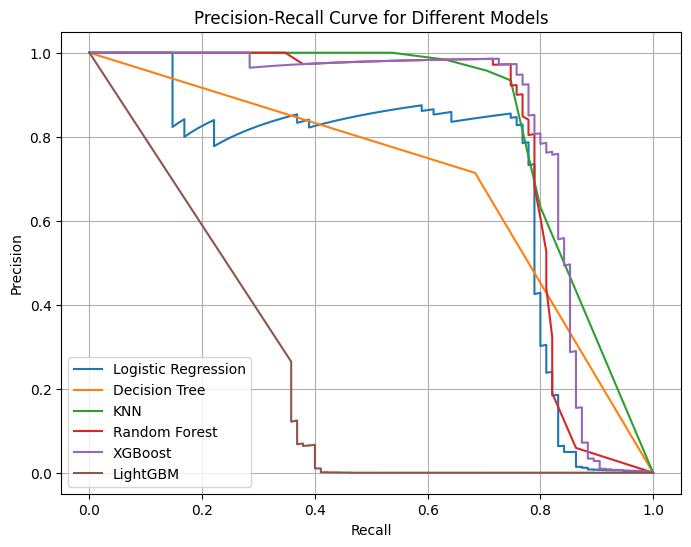

SMOTE


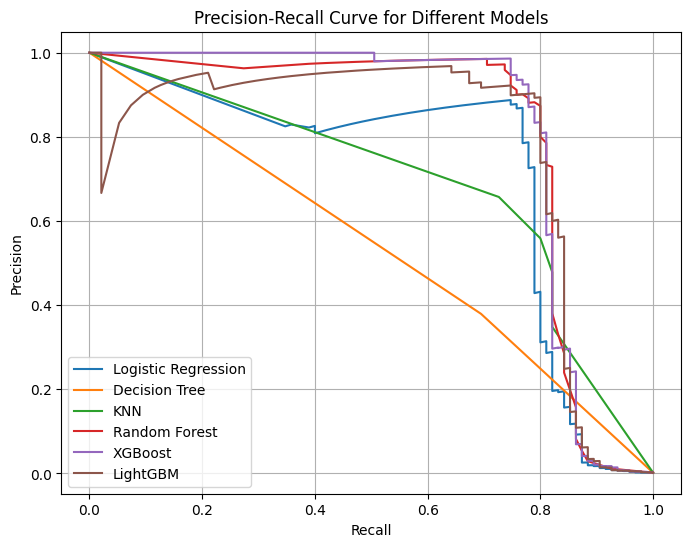

Random Undersampling


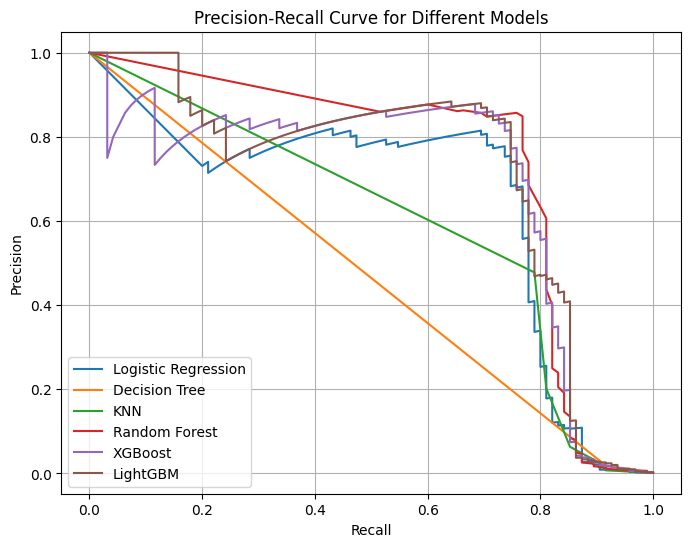

In [ ]:
# PR-Curves
print('Imbalanced')
plot_pr_curves(model_pr_curves_pt1)
print('SMOTE')
plot_pr_curves(model_pr_curves_pt2_smote)
print('Random Undersampling')
plot_pr_curves(model_pr_curves_pt2_rus)

Based on default thresholds, balanced datasets yield much higher recall scores but lack precision. However, we can see from the PR-Curves that performance is pretty close overall between SMOTE and , just using different thresholds.

Balanced and imbalanced data have tradeoffs, which we can better visualize when plotting PR-Curves of each specific algorithm separately.

In [ ]:
# Function to plot balanced vs. imbalanced trained models next to each other (only one algorithm at a time)

def plot_smote_rus_imbalanced(algorithm):

  plt.figure(figsize=(8,6))

  plt.plot(model_pr_curves_pt1[algorithm]['recall'], model_pr_curves_pt1[algorithm]['precision'], label='Imbalanced')
  plt.plot(model_pr_curves_pt2_smote[algorithm]['recall'], model_pr_curves_pt2_smote[algorithm]['precision'], label='SMOTE')
  plt.plot(model_pr_curves_pt2_rus[algorithm]['recall'], model_pr_curves_pt2_rus[algorithm]['precision'], label='Random Undersampling')

  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title(f'Precision-Recall Curve for {algorithm}')
  plt.legend(loc='best')
  plt.grid(True)
  plt.show()

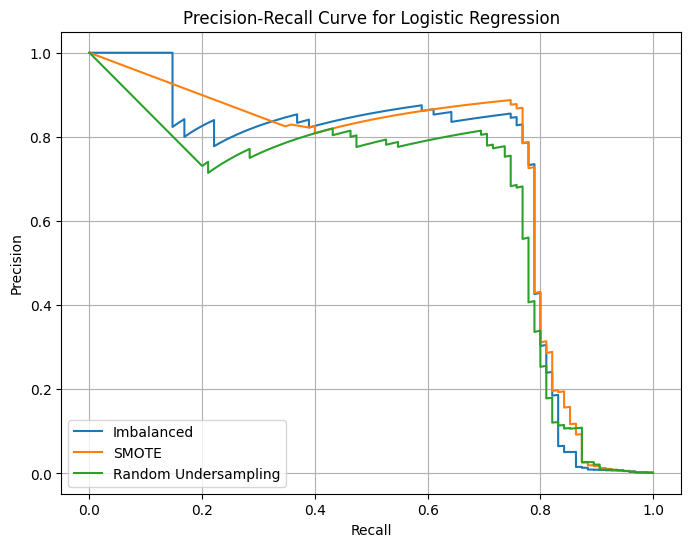

In [ ]:
kplot_smote_rus_imbalanced('Logistic Regression')

- Performance seems to be extremely close between SMOTE and imbalanced, not as strong for random undersampling
- However, both undersampling and SMOTE work better in achieving higher recall scores and decreasing the threshold

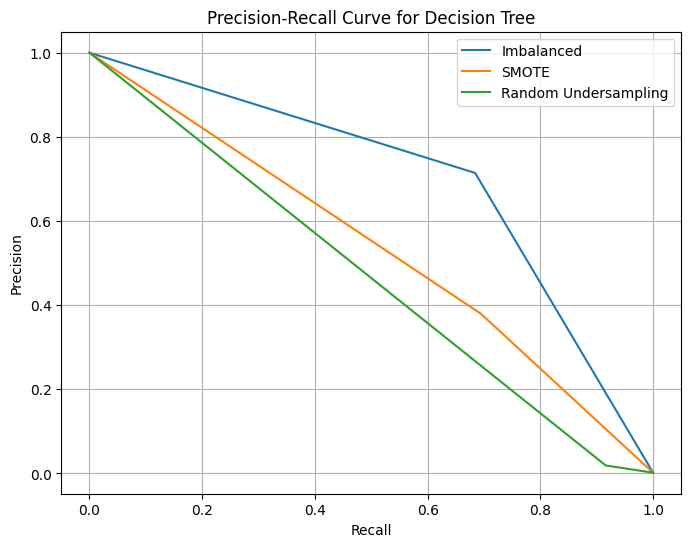

In [ ]:
plot_smote_rus_imbalanced('Decision Tree')

- Imbalanced > SMOTE > Random Undersampling, under all circumstances

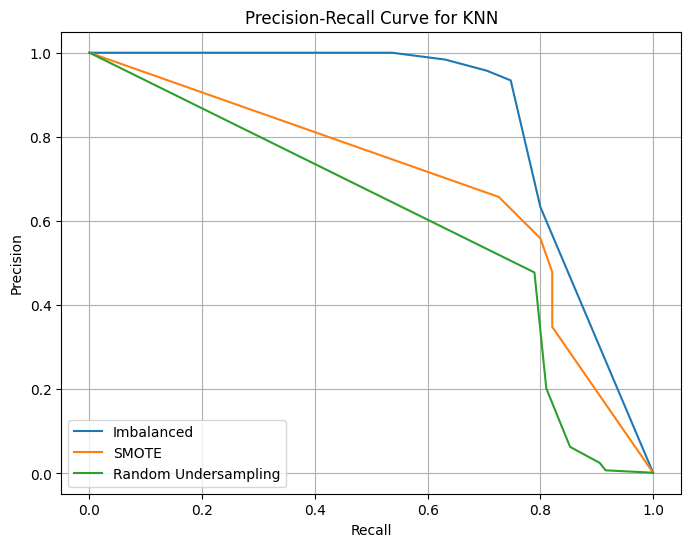

In [ ]:
plot_smote_rus_imbalanced('KNN')

- Imbalanced > SMOTE > Random Undersampling, under all circumstances

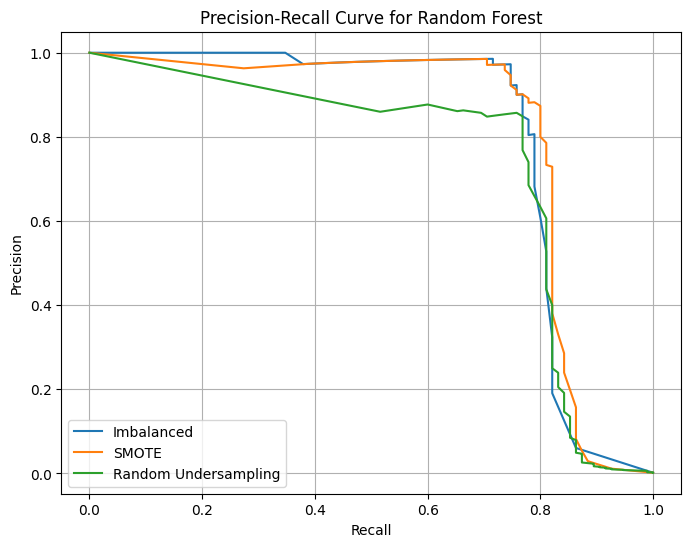

In [ ]:
plot_smote_rus_imbalanced('Random Forest')

- Very close throughout

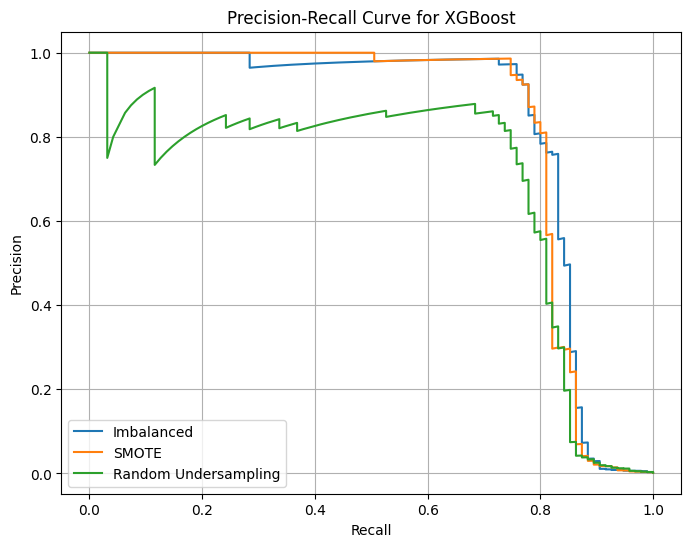

In [ ]:
plot_smote_rus_imbalanced('XGBoost')

- Close between SMOTE and Imbalanced, as well as undersampled model when decreasing the threshold
- Imbalanced performs much better at a few viable thresholds

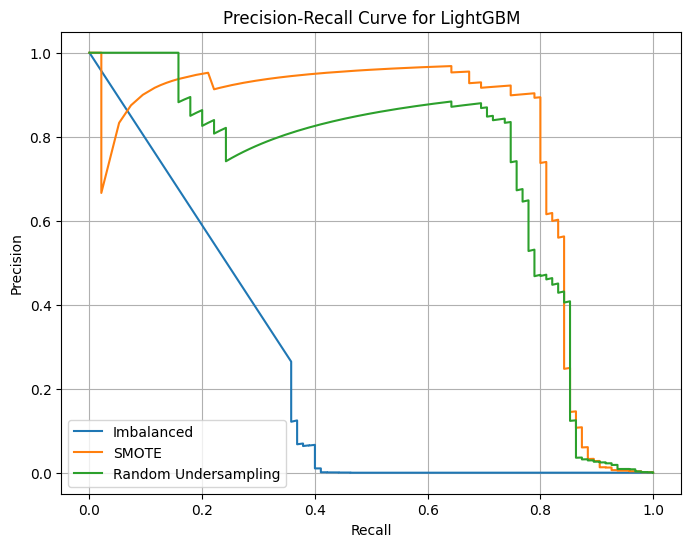

In [ ]:
plot_smote_rus_imbalanced('LightGBM')

- Imbalanced model performs poorly
- SMOTE performs better than undersampling for the most part, but the results are close as threshold decreases

# Scaling/Balancing Conclusion

## Standardization
- Scaling isn't necessarily helpful
- In our case, using Standard Scaler on PCA-engineered data hurt performance throughout
- There could be a few reasons for this
 - Over-engineering causes loss of valuable information
 - Wrong scaler choice

## Balancing
- Ultimately depends on the model you use and the problem you are solving
 - For some algorithms, balanced data was required (e.g., LightGBM)
 - For other cases, training on the original dataset led to better results consistently (e.g., KNN and Decision Trees)
- In many cases, there are tradeoffs between using balanced and imbalanced data
 - Performance depends on selected threshold
 - Selected threshold depends on our willingness to sacrifice precision

Based on the PR-Curves, we have a few choices for best model:

- For Recall at 80%: LightGBM trained on SMOTE data
- For Recall > 80% and < ~86%: XGBoost trained on original data
- For Recall >~86%: KNN on original data

Since recall is the most important metric and a mistaken fraud classification isn't extremely harmful, KNN on original data is the winner

# Future Steps and Considerations

- Don't rule out standardization or LightGBM right away. Models trained on scaled data didn't perform well using default thresholds but the PR-Curve showed closer results than expected. Standardized data also improved LightGBM, and SMOTE improved LightGBM substantially, but I didn't test the two together because I completely disregarded LightGBM after its initial performance.
- Consider other potential models such as SVM (I didn't in this project because it is computationally expensive and performs better on lower dimensional data, but it might work well with undersampling).
- Once best models are selected, use grid search to tune model parameters